In [1]:
import pickle
import pandas as pd
import numpy as np
from Bio import SeqIO
from pprint import pprint

In [2]:
titers = pickle.load(open('./raw_titers.p', 'rb')) # Titers
genotypes = pd.read_csv('../data/smith2015/genotypes.csv') 
genotypes = { i[0]:i[1] for i in zip(genotypes['accession'], genotypes['RicoGenotype']) } # Accession : Genotypes
viruses = [ v.description for v in 
           SeqIO.parse(open('/Users/Sidney/nextstrain/fauna/data/dengue.fasta', 'r'), 'fasta')] # Headers -> Acc : Strain
strain_genotypes = {'DENV2/PAPUANEWGUINEA/NEWGUINEAC/1944':'Southeast Asia', 'DENV2/PERU/IQT2913/1996': 'American'}
for v in viruses:
    strain, acc = v.split('|')[:2]
    if acc in genotypes:
        strain_genotypes[strain] = genotypes[acc] # Strain : Genotype

In [3]:
for t in titers: # Genotype : Titers
    t['serum_serotype'] = t['serumID'].split('/')[0]
    t['virus_serotype'] = t['virus'].split('/')[0]
    t['serum_genotype'] = t['serum_serotype']+strain_genotypes[t['serumID'].split('|')[0]]
    t['virus_genotype'] = t['virus_serotype']+strain_genotypes[t['virus']]
titers = pd.DataFrame(titers, columns=['virus', 'virus_serotype', 'virus_genotype', 'serumID', 'serum_serotype', 'serum_genotype', 'titer'])
titers['log2_titer'] = np.log2(titers['titer'])    

In [16]:
def find_autologous(sera, titer_vals):
    autologous_vals = []  
    for s in sera:
        try:
            a = titers.loc[(titers['virus'] == s.split('|')[0]) &       # Find where virus = sera
                (titers['serumID'] == s) ]['log2_titer']                # and sera = sera
            assert len(a) <= 1 # Should be exactly 1 autologous value
            autologous_vals.append(a.values[0])
        except AssertionError:
            print 'Multiple autologous titers found for this serum:'
            print titers.loc[(titers['virus'] == s.split('|')[0]) & (titers['serumID'] == s) ]
            raise AssertionError
        except IndexError:
            autologous_vals.append(None)
    
    normalized_vals = []
    for autologous, raw in zip(autologous_vals, titer_vals):
        if autologous != None:
            normalized_vals.append(autologous - raw)
        else:
            normalized_vals.append(None)
    return pd.Series(normalized_vals)
    
def find_max(sera, titer_vals):
    max_vals = [ titers.groupby(['serumID'])['log2_titer'].max()[s] for s in sera ]
    normalized_vals = [ Max - raw for Max, raw in zip(max_vals, titer_vals) ]
    return pd.Series(normalized_vals)

titers['autologous_norm'] = find_autologous(titers['serumID'], titers['log2_titer'])
titers['max_norm'] = find_max(titers['serumID'], titers['log2_titer'])

In [6]:
print pd.value_counts(titers['virus_genotype'])

def code_colors(virus_genotypes, sera_serotypes):
    recode = []
    for (v, s) in zip(virus_genotypes, sera_serotypes):
        if s == 'DENV1':
            if v == 'DENV2American':
                recode.append('american')
            elif v == 'DENV2Southeast Asia' :
                recode.append('asian')
            else:
                recode.append('')
        else:
            recode.append('')
    return pd.Series(recode)

titers['homotypic'] = titers['virus_serotype'] == titers['serum_serotype']
titers['Kochel'] = code_colors(titers['virus_genotype'], titers['serum_serotype'])
print titers.columns.values

DENV2Southeast Asia                  299
DENV4Southeast Asia                  110
DENV2American                        101
DENV3Thailand                        100
DENV4Indonesia                        92
DENV3Indian Subcontinent              81
DENV1Americas-Africa                  79
DENV1Asian                            78
DENV2Malaysia/Indian Subcontinent     62
DENV1Thailand                         46
DENV3Southeast Asia/South Pacific     39
DENV2Malaysian                        36
DENV4Sylvatic                         32
DENV3Americas                         25
DENV2Sylvatic                         16
DENV1South Pacific                    13
Name: virus_genotype, dtype: int64
['virus' 'virus_serotype' 'virus_genotype' 'serumID' 'serum_serotype'
 'serum_genotype' 'titer' 'log2_titer' 'autologous_norm' 'max_norm'
 'sero_match' 'divergence' 'homotypic' 'Kochel']


In [5]:
divergence = pickle.load(open('./divergence.p', 'rb'))
tidy_divergence = []
for index, series in titers.iterrows():
    tidy_divergence.append(divergence.at[series['serumID'].split('|')[0], series['virus']])
titers['divergence'] = pd.Series(tidy_divergence)

In [7]:
genotype_groups = titers.groupby(['serum_genotype', virus_genotype', 'homotypic'], as_index=False)
genotype_titers = genotype_groups.aggregate(np.mean)

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

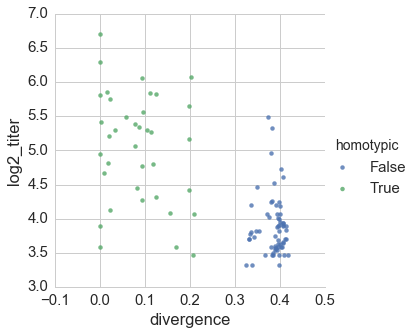

In [9]:
sns.set(style='whitegrid', font_scale=1.5)
sns.lmplot('divergence', 'log2_titer', data=genotype_titers, hue='homotypic', fit_reg=False)


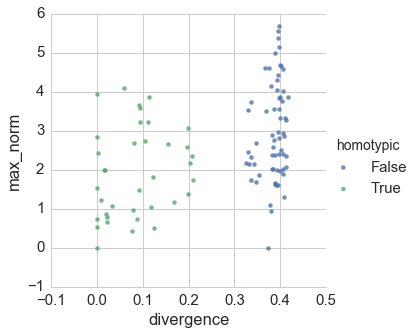

In [10]:
sns.lmplot('divergence', 'max_norm', data=genotype_titers, hue='homotypic', fit_reg=False)

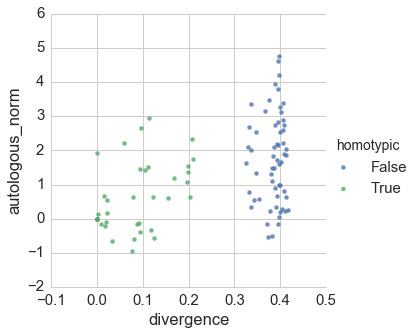

In [11]:
sns.lmplot('divergence', 'autologous_norm', data=genotype_titers, hue='homotypic', fit_reg=False)

In [15]:
print genotype_titers[(genotype_titers['serum_genotype']=='DENV2American') & 
                      (genotype_titers['virus_genotype'] == 'DENV2American')]

   serum_genotype virus_genotype homotypic      titer  log2_titer  \
46  DENV2American  DENV2American      True  56.318182     5.41843   

    autologous_norm  max_norm sero_match  divergence  
46         0.149501   2.43934       True    0.002159  


In [ ]:
intraserotype = 